In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.text import *

In [3]:
import sentencepiece as spm

In [4]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'

In [5]:
device = torch.device('cpu')#torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Helpers

In [5]:
def standardize_imgs(imgs, baseheight):
    resized_imgs = []
    for img in imgs:
        hpercent = (baseheight / float(img.size[1]))
        wsize = int((float(img.size[0]) * float(hpercent)))
        img = img.resize((wsize, baseheight), PIL.Image.ANTIALIAS)
        resized_imgs.append(img)
    return resized_imgs

In [6]:
def resize_max(im, size=1000):
    "Resize an image so that the largest dimension is of specified size"
    r,c = im.size
    ratio = size/max(r,c)
    return im.resize((int(r*ratio), int(c*ratio)), Image.ANTIALIAS)

In [7]:
def square_max(im, top_left=False, size=None):
    '''
    Add whitespace to square an image by its largest dimension or specified size.
    Args:
        top_left: image is aligned with the top_left corner
        size: size of final squared image.  If left blank size = largest dimension
    '''
    
    r,c = im.size
    if size is not None and size > max(r,c):
        sz = size
    else:
        sz = max(r,c)
        
    new_im = Image.new('RGB', (sz, sz), color=(255,255,255))  # new white image
    
    # box logic
    if top_left:
        box = (0,0)
    else:
        if sz == r:
            box = (0,random.randint(0,sz-c)) 
        elif sz == c:
            box = (random.randint(0,sz-r),0)
        else:
            box = (random.randint(0,sz-r),random.randint(0,sz-c))
            
    new_im.paste(im, box=box)
    return new_im

In [8]:
def resize_dir(fn, src, targ=None):
    if targ is None: targ = src
    dirs = os.listdir(src)
    for item in tqdm(dirs):
        if os.path.isdir(src/item): continue     # skip if src dir
#         if os.path.isfile(targ/item): continue   # skip if file exists in targ dir
        im = Image.open(src/item)
        rsz = fn(im)
        rsz.save(targ/item)
        rsz.close()
        im.close()

In [9]:
def resize_to_square(src_dir, targ_dir, size):
    "Resize and square all images in src_dir and save in targ_dir"
    resize_dir(partial(resize_max, size=size), src_dir, targ_dir)
    resize_dir(square_max, targ_dir)

In [10]:
def show_sample(df, path, row=2, col=2):
    fig, axes = plt.subplots(row,col, figsize=(20, 10))
    for i,ax in enumerate(axes.flat):
        row = df.iloc[i]
        im = Image.open(path/row.filename)
        ax.imshow(im)
        label = row.labels
    #     label = '\n'.join(textwrap.wrap(row.labels, 70))
        ax.set_title(label)

    plt.tight_layout(pad=0.2)

# Synthesize Lines

## From DataFrame

In [6]:
df = pd.read_csv(f'{PATH}/ascii/lines.txt', names=['filename','result','value'], escapechar='\\',
                          delim_whitespace=True, skiprows=23, header=None, usecols=[0,1,8])
df['text'] = df.apply(lambda row: row.value.replace('|', ' '), axis=1)

In [7]:
def cleanup(x):
    x = re.sub(r" \'(\w+)", lambda x: x.group(0)[1:], x)     # match all space and apostrophe letters
    x = re.sub(r" [.,?!:;()]", lambda x: x.group(0)[1:], x)  # match all space and punctuation
    return x

df['text'] = df.apply(lambda row: cleanup(row.text), axis=1)

In [8]:
# calculate character lengths
lgts = df.text.apply(len)  
df['text_len'] = lgts.astype('int32')

df.tail()

,filename,result,value,text,text_len
13346,r06-143-00,ok,In|the|train|going|back|to|London|I|sat,In the train going back to London I sat,39
13347,r06-143-01,ok,beside|#|Catherine|.|She|had|the|stories|open,beside # Catherine. She had the stories open,44
13348,r06-143-02,ok,"in|front|of|her|,|but|she|said|:|'|Philip|'s|a...","in front of her, but she said: ' Philip's awfu...",56
13349,r06-143-03,ok,I|wish|I|went|to|that|school|.|Did|you|notice,I wish I went to that school. Did you notice,44
13350,r06-143-04,ok,that|girl|who|said|hullo|to|him|in|the|garden|?,that girl who said hullo to him in the garden?,46


In [9]:
# df = df[df.result != 'err']
# df = df.loc[df['text_len'] > 20]
len(df)

13351

In [ ]:
# df.text_len.min(), df.text_len.median(), df.text_len.max()

In [10]:
name = str(PATH/'spm_train')
fname = name + '.txt'

In [11]:
# puts dataset into format expected by sentencepiece:
# .txt file entries separated by \n
def write_text(texts, filename=fname):
    with open(filename, 'w', encoding='utf-8') as f:
        for text in texts:
            f.write(text + "\n")

In [12]:
write_text(df.text.values)

In [13]:
spm.SentencePieceTrainer.Train(
    f"--unk_id=3 --pad_id=0 --input={fname} --model_prefix={name} --vocab_size=1000 --user_defined_symbols=</n>"
)

True

In [18]:
sp = spm.SentencePieceProcessor()
sp.Load(name+'.model')

True

In [31]:
sp.piece_to_id('7')

3

In [16]:
vocab = {i: sp.id_to_piece(i) for i in range(1000)}

In [17]:
vocab

{0: '<pad>',
 1: '<s>',
 2: '</s>',
 3: '<unk>',
 4: '</n>',
 5: 's',
 6: '▁the',
 7: '.',
 8: ',',
 9: '▁',
 10: '▁a',
 11: '▁of',
 12: 'e',
 13: 't',
 14: 'ed',
 15: '▁to',
 16: '▁and',
 17: '▁in',
 18: 'ing',
 19: 'a',
 20: 'n',
 21: 'd',
 22: 'r',
 23: 'o',
 24: 'p',
 25: 'y',
 26: 'm',
 27: 'c',
 28: '▁"',
 29: 'i',
 30: 'er',
 31: '▁s',
 32: 'l',
 33: '▁was',
 34: "'",
 35: 'ly',
 36: '-',
 37: '▁that',
 38: 'u',
 39: 'ar',
 40: '▁he',
 41: 'g',
 42: '▁is',
 43: '▁be',
 44: 'h',
 45: 'al',
 46: '▁for',
 47: '▁f',
 48: 'in',
 49: 'b',
 50: 're',
 51: '▁I',
 52: 'or',
 53: "▁'",
 54: '▁with',
 55: '▁on',
 56: 'it',
 57: '▁b',
 58: '▁had',
 59: '▁his',
 60: 'f',
 61: '▁The',
 62: '▁it',
 63: '▁re',
 64: 'le',
 65: 'en',
 66: '▁A',
 67: 'at',
 68: '▁as',
 69: 'an',
 70: 'w',
 71: '▁at',
 72: 'k',
 73: 'es',
 74: 'ent',
 75: '▁p',
 76: '▁not',
 77: 'st',
 78: '▁de',
 79: '▁by',
 80: 'ur',
 81: 'ch',
 82: '▁an',
 83: '▁P',
 84: '▁B',
 85: 'th',
 86: 'ro',
 87: '▁her',
 88: '▁He',
 89: 

In [95]:
def encode_text(lines, sp):
    encodedtext = []
    for line in lines:
        encodedtext.append([1]+sp.encode_as_ids(line)+[2])
    return encodedtext

ids = encode_text(df.text.values, sp)

In [97]:
ids

[[1, 65, 147, 246, 891, 143, 12, 88, 196, 107, 8, 989, 99, 2],
 [1, 142, 40, 50, 62, 17, 308, 184, 467, 352, 87, 13, 182, 2],
 [1, 37, 12, 38, 295, 77, 9, 742, 10, 467, 2],
 [1, 147, 576, 4, 943, 8, 107, 8, 147, 26, 74, 20, 134, 176, 22, 209, 113, 2],
 [1, 492, 430, 9, 68, 676, 55, 5, 658, 2],
 [1, 15, 35, 37, 12, 38, 313, 14, 79, 107, 8, 227, 239, 2],
 [1,
  171,
  94,
  240,
  26,
  85,
  4,
  7,
  147,
  576,
  42,
  351,
  18,
  74,
  222,
  27,
  207,
  186,
  74,
  398,
  13,
  8,
  2],
 [1,
  65,
  147,
  246,
  891,
  143,
  12,
  88,
  196,
  107,
  8,
  989,
  99,
  142,
  40,
  50,
  62,
  17,
  2],
 [1, 308, 184, 467, 352, 87, 13, 182, 37, 12, 38, 295, 77, 9, 2],
 [1, 742, 10, 467, 285, 501, 576, 4, 943, 8, 107, 8, 147, 26, 74, 20, 134, 2],
 [1, 176, 22, 209, 113, 492, 430, 9, 68, 676, 55, 5, 658, 2],
 [1,
  15,
  35,
  37,
  12,
  38,
  313,
  14,
  79,
  107,
  8,
  227,
  239,
  171,
  94,
  240,
  26,
  85,
  4,
  7,
  2],
 [1, 285, 501, 576, 42, 351, 18, 74, 222, 27, 2

## remove lines in paragraph validation set

In [13]:
# get paragraph val idxs
PG_CSV = PATH/'paragraph_chars.csv'
pg_csv = pd.read_csv(PG_CSV)
val_idxs = np.array(pg_csv.sample(frac=0.15, random_state=42).index)

In [14]:
names = pg_csv.filename[val_idxs].values
names = [name[:-4] for name in names]

In [15]:
fnames = df.filename.values
fnames = [name[:-3] for name in fnames]

In [16]:
st = set(names)
vals = [i for i, e in enumerate(fnames) if e in st]
len(vals), len(fnames)

(1638, 10940)

In [17]:
# remove vals from df
df.drop(df.index[vals], inplace=True)
len(df)

9302

## Create Data

In [18]:
def create_img(imgs, targ_path, num_lines, max_size, pad=30):
    w = 1
    h = num_lines
        
    widths, heights = zip(*(i.size for i in imgs))
    
    median_height = int(np.median(heights))
    stzd_imgs = standardize_imgs(imgs, median_height)
    lines = [stzd_imgs[i:i + w] for i in range(0, len(stzd_imgs), w)]
    
    total_width = max([np.sum([word.size[0] for word in line]) for line in lines]) + (pad*(w+1))   
    total_height = (median_height * h) + (pad*(h+1)) #sum(heights)

    new_im = Image.new('RGB', (total_width, total_height), color=(255,255,255))

    y_offset = pad
    x_offset = pad
    
    for line in lines:
        x_offset = pad
        for word in line:
            new_im.paste(word, (x_offset,y_offset))
            x_offset += word.size[0] + pad
        y_offset += median_height + pad
    
    if max_size: 
        resize_max(new_im, max_size).save(targ_path)
    else:
        new_im.save(targ_path/fname)

In [19]:
# number of words/image
def create_synth_data(num, num_lines, src_path, targ_path, max_size=1000, offset=0):
    d={}
    for i in tqdm(range(num)):
        samp = df.sample(num_lines)
        files = list(map(lambda x: x+'.png', samp.filename.values))
        imgs  = [Image.open(src_path/f) for f in files]
        
        # split into rows with \n
        label = '\n'.join([' '.join(row) for row in np.array_split(samp.text.values, num_lines)])
#         label = ' '.join(samp.text.values)

        fname = str(num_lines)+'_'+'{:04d}'.format(i+offset)+'.png'
        create_img(imgs, targ_path/fname, num_lines, max_size)
        [f.close() for f in imgs]
        d[fname] = label
    return d

In [20]:
src_path = PATH/'lines'
targ_path = PATH/'cat_lines'

In [21]:
#single
num_lines = 3
d = create_synth_data(10, num_lines, src_path, targ_path)
len(d)

100%|██████████| 10/10 [00:01<00:00,  9.77it/s]


10

In [22]:
synth = pd.DataFrame({'filename': list(d.keys()), 'labels': list(d.values())})
synth.head()

,filename,labels
0,3_0000.png,"what you 'd get, "" she flashed at him, and\nme..."
1,3_0001.png,energetic man with a gentle and charming chara...
2,3_0002.png,tax relief for a jacket used\nand aesthetic as...
3,3_0003.png,disciples among unorthodox medical men in the\...
4,3_0004.png,"to emerge carrying his shame unseen, but burni..."


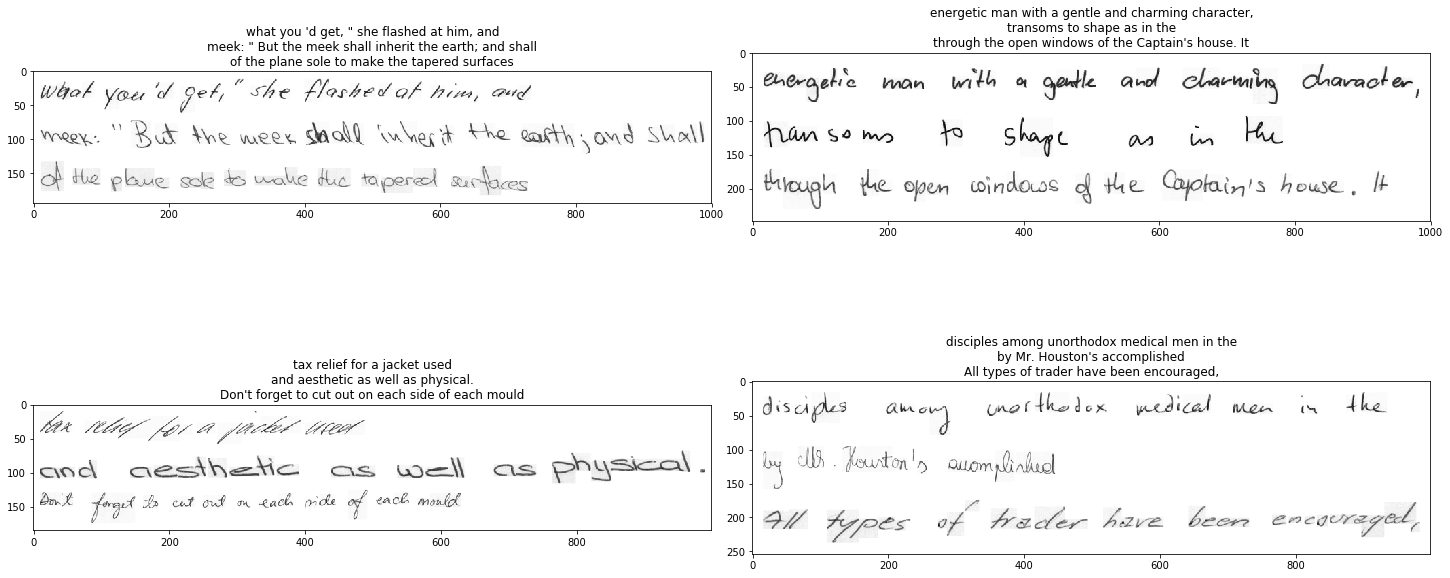

In [28]:
show_sample(synth, targ_path)

In [44]:
#multi
for i in tqdm(range(3,15)):   #tqdm([11,12,13,14]):   #tqdm([7,8,9,10]):
    num_lines = i
    d = create_synth_data(1000, num_lines, src_path, targ_path)
    synth = pd.DataFrame({'filename': list(d.keys()), 'labels': list(d.values())})
    
    joined_labels = list(synth.labels) #list(map(lambda x: ' '.join(x), labels))

    stoi = collections.defaultdict(lambda: 82, {v:k for k,v in enumerate(itos)})
    ids = np.array([np.array([stoi[letter] for letter in word] + [3]) for word in joined_labels])

    # convert to strings (as labels)
    str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)
    synth['char_ids'] = str_ids
    
    CSV = str(targ_path)+'_'+str(num_lines)+'.csv'
    synth.to_csv(CSV, columns=['filename', 'char_ids'], index=False)

100%|██████████| 12/12 [43:29<00:00, 217.44s/it]

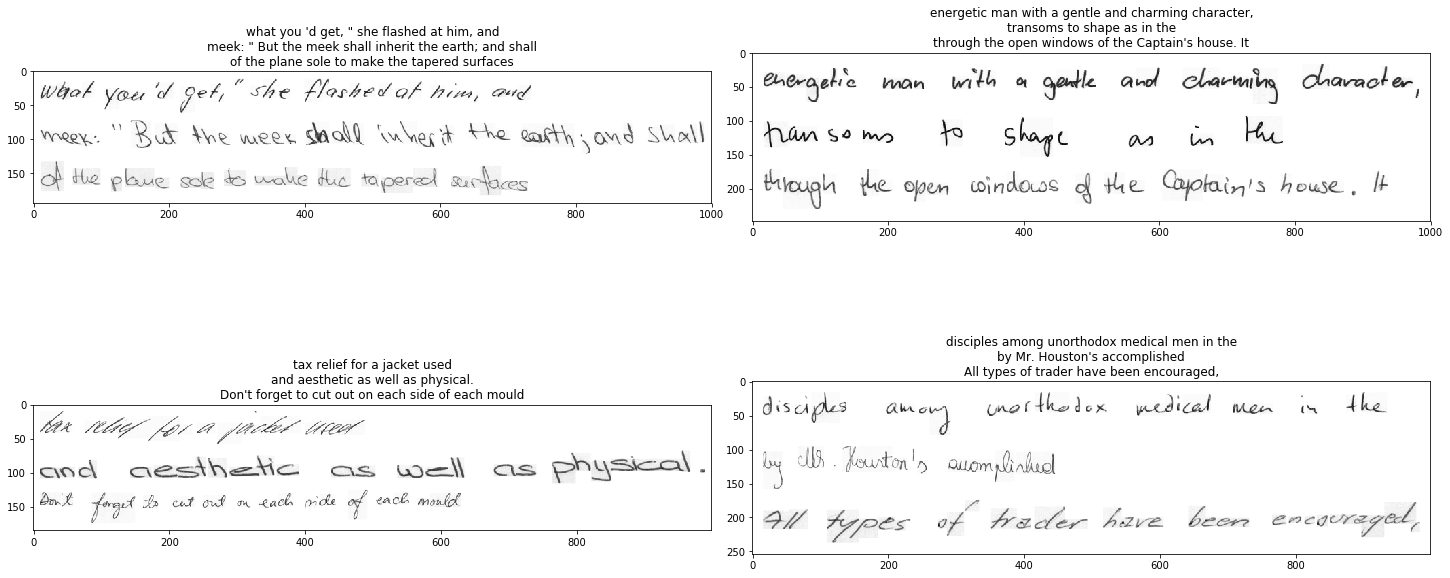

In [28]:
show_sample(a, targ_path)

# Synthesize Words

### From pd.read_csv

In [65]:
df = pd.read_csv(f'{PATH}/ascii/words.txt', names=['filename','result','value'], escapechar='\\', delim_whitespace=True, skiprows=23, header=None, usecols=[0,1,8])
df.rename(columns={'value': 'word'}, inplace=True)
len(df)

75597

In [66]:
# remove errors
df = df[df.result != 'err']
len(df)

64750

In [67]:
# calculate character lengths
lgts = df.word.apply(len)  
df['char_len'] = lgts.astype('int32')

In [68]:
# lots of errors from pd.read_csv
# only keep rows w/ word length < 20
df = df[df.char_len < 20]

In [69]:
df = df.loc[df['char_len'] > 3]

In [70]:
df.head()

,filename,result,word,char_len
0,a01-000u-00-05,ok,Gaitskell,9
1,a01-000u-00-06,ok,from,4
2,a01-000u-01-00,ok,nominating,10
4,a01-000u-01-02,ok,more,4
5,a01-000u-01-03,ok,Labour,6


### via manually created DF

In [78]:
maxTextLen = 32
samples = []
chars = set()

f=open(f'{PATH}/ascii/words.txt')
for line in f:
    # ignore comment line
    if not line or line[0]=='#':
        continue

    lineSplit = line.strip().split(' ')
    assert len(lineSplit) >= 9

    fileName = lineSplit[0]

    # GT text are columns starting at 9
    gtText = ''.join(lineSplit[8:])[:maxTextLen]
    char_len = len(gtText)
    chars = chars.union(set(list(gtText)))

    # put sample into list
    samples.append([fileName, gtText, char_len])
    
samples = np.stack(samples)
df = pd.DataFrame(samples, columns=['filename', 'word', 'char_len'], )
del samples

In [79]:
df['char_len'] = df.char_len.astype('int32')
df = df.loc[df['char_len'] > 3]
df = df.loc[df['char_len'] < 20]
df.head()

,filename,word,char_len
1,a01-000u-00-01,MOVE,4
3,a01-000u-00-03,stop,4
5,a01-000u-00-05,Gaitskell,9
6,a01-000u-00-06,from,4
7,a01-000u-01-00,nominating,10


## num words / line

In [71]:
def create_img(src_path, targ_path, files, fname, sz=None, pad=30):
    if sz==None: sz=(1, len(files))  #(w,h)
    w = sz[1]
    h = sz[0]
        
    imgs = [ PIL.Image.open(src_path/f) for f in files ]
    widths, heights = zip(*(i.size for i in imgs))
    
    median_height = int(np.median(heights))
    stzd_imgs = standardize_imgs(imgs, median_height)
    lines = [stzd_imgs[i:i + w] for i in range(0, len(stzd_imgs), w)]
    
    total_width = max([np.sum([word.size[0] for word in line]) for line in lines]) + (pad*(w+1))   
    total_height = (median_height * h) + (pad*(h+1)) #sum(heights)

    new_im = Image.new('RGB', (total_width, total_height), color=(255,255,255))

    y_offset = pad
    x_offset = pad
    
    for line in lines:
        x_offset = pad
        for word in line:
            new_im.paste(word, (x_offset,y_offset))
            x_offset += word.size[0] + pad
        y_offset += median_height + pad
        
    new_im.save(targ_path/fname)

In [85]:
# number of words/image
def create_synth_data(src_path, targ_path, num, sz, offset=0, randomize=False, pre=''):
    d={}
    for i in tqdm(range(num)):
        if randomize:
            r = random.randint(1,sz[0])
            c = random.randint(1,sz[1])
        else:
            r,c = sz
            
        num_samp = np.product((r,c))
        res = df.sample(num_samp)
        files = list(map(lambda x: x+'.png', res.filename.values))
        
        # split into rows with \n
        label = '\n'.join([' '.join(row) for row in np.array_split(res.word.values, r)])
#         label = ' '.join(res.word.values)
        
        fname = pre+'{:04d}'.format(i+offset)+'.png'
        create_img(src_path, targ_path, files, fname, (r,c))
        d[fname] = label
    return d

In [91]:
src_path = PATH/'words'
synth_path = PATH/'small_synth_words'
!rm -rf {synth_path}

os.makedirs(synth_path, exist_ok=True)

In [92]:
d = create_synth_data(src_path, synth_path, 20000, (4,3), randomize=True, pre='sm_')
len(d)

100%|██████████| 20000/20000 [19:41<00:00, 16.92it/s]


20000

In [99]:
synth = pd.DataFrame({'filename': list(d.keys()), 'labels': list(d.values())})
synth.head()

,filename,labels
0,sm_0000.png,people\ngoing\nother
1,sm_0001.png,something\nmanaged
2,sm_0002.png,Make
3,sm_0003.png,Secretary\nwhich\nappreciated
4,sm_0004.png,affection disciples with\nhowever Labour offer...


In [80]:
# resize_dir(partial(resize_max, size=512), src_path)
resize_dir(partial(square_max, size=1000), synth_path)

100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


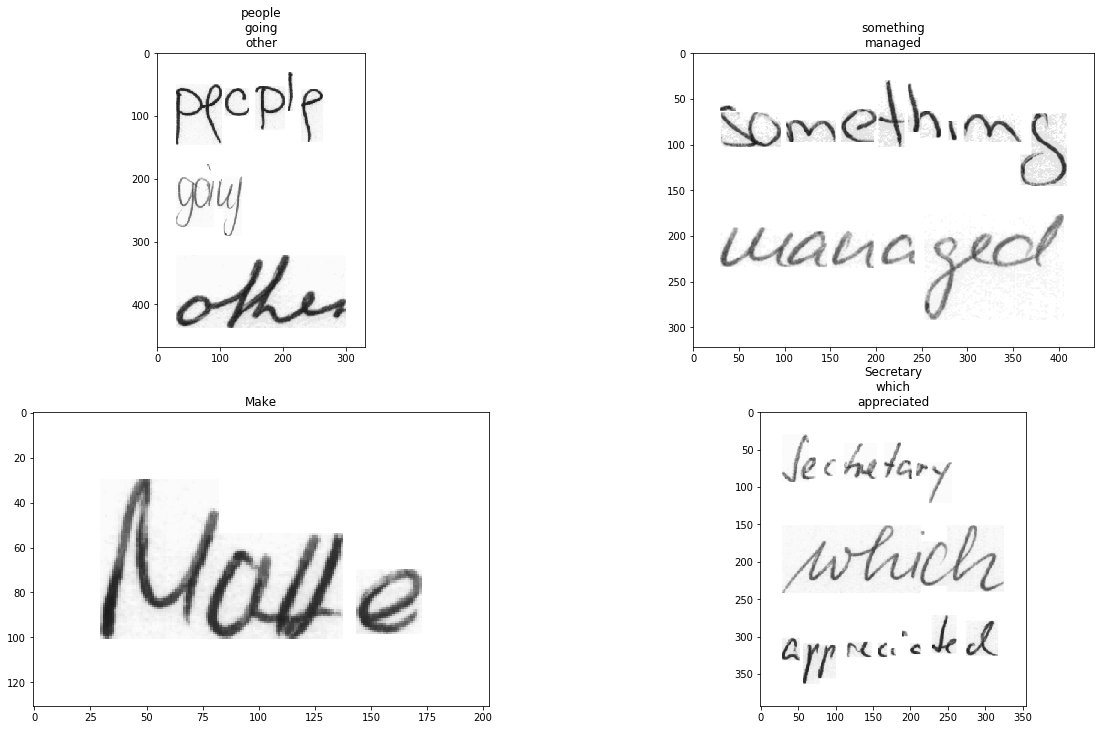

In [100]:
show_sample(synth, synth_path)

## size of image

In [111]:
synth_path = PATH/'large_synth_words_test'
!rm -rf {synth_path}

os.makedirs(synth_path, exist_ok=True)

In [105]:
def create_img(sz, fname, pad=30, median_height=None):
    # TODO: randomize padding
    new_im = Image.new('RGB', (sz,sz), color=(255,255,255))
    
    res   = df.sample(50)
    files = list(map(lambda x: x+'.png', res.filename.values))
    lbls  = res.word.values.tolist()
    imgs  = [ PIL.Image.open(PATH/'words'/f) for f in files ]
    
    if median_height is None:
        w, h  = zip(*(i.size for i in imgs))
        # standardize heights and sort longest to shortest words
        median_height = int(np.median(h))        # TODO: randomize this between mean/std
        
    stzd_imgs = standardize_imgs(imgs, median_height)
    
    #loop through standardized images and find the next image which satisfies the condition
    labels = []
    y_offset = pad
    while y_offset+median_height+pad < sz:        
        x_offset = pad
        
        gen = (i for i,x in enumerate(stzd_imgs) if x.size[0]+x_offset+pad <= sz)
        lines = []
        for idx in gen:
            word = stzd_imgs.pop(idx)            
            lines.append(lbls.pop(idx))
            new_im.paste(word, (x_offset,y_offset))
            x_offset += word.size[0] + pad
        y_offset += median_height+pad
        labels.append(' '.join(lines))

    new_im.save(synth_path/fname)    
    return '\n'.join(labels)

In [112]:
# size of image
def create_synth_data(qty, sz, fname_offset=0):
    d={}
    for i in tqdm(range(qty)):
        fname = '{:04d}'.format(i+fname_offset)+'.png'
        p = random.randint(10,20)
        h = random.randint(25,35)
        d[fname] = create_img(sz, fname, pad=p, median_height=h)
    return d

d = create_synth_data(20000, 512)
len(d)
# ~25min to create 5000 1000x1000 images

100%|██████████| 20000/20000 [39:45<00:00,  8.39it/s]


20000

In [113]:
synth = pd.DataFrame({'filename': list(d.keys()), 'labels': list(d.values())})
synth.head()

,filename,labels
0,0000.png,Labour left ENOUGH MULE named\ncinema height y...
1,0001.png,shown founder express UNRELIABLE\nAnson surpri...
2,0002.png,less even have gentle looked\nreally personal ...
3,0003.png,Usually depend would being Leipzig\nviable dis...
4,0004.png,clearing contents last readily Camp\ndescri- s...


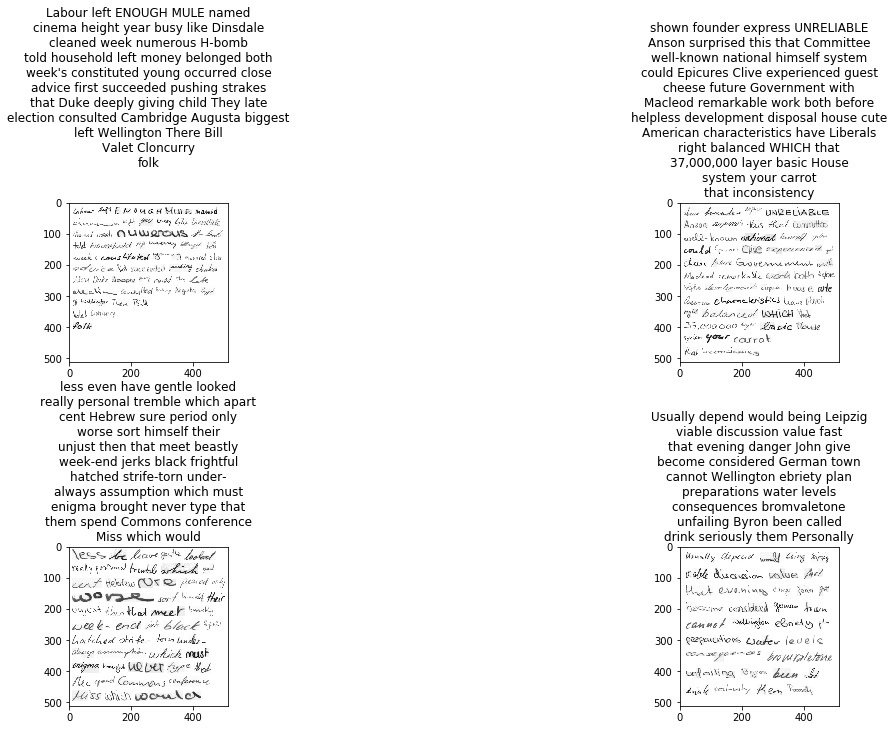

In [114]:
show_sample(synth, synth_path)

# Numericalize

## Chars

In [17]:
# same as used in single word / multi-word
itos = pickle.load(open(TMP_PATH/'char_itos.pkl', 'rb'))
len(itos)

82

In [115]:
joined_labels = list(synth.labels) #list(map(lambda x: ' '.join(x), labels))

stoi = collections.defaultdict(lambda: 82, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[letter] for letter in word] + [3]) for word in joined_labels])

# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [116]:
synth['char_ids'] = str_ids
synth.head()

,filename,labels,char_ids
0,0000.png,Labour left ENOUGH MULE named\ncinema height y...,41 56 57 70 76 73 1 67 60 61 75 1 34 43 44 50 ...
1,0001.png,shown founder express UNRELIABLE\nAnson surpri...,74 63 70 78 69 1 61 70 76 69 59 60 73 1 60 79 ...
2,0002.png,less even have gentle looked\nreally personal ...,67 60 74 74 1 60 77 60 69 1 63 56 77 60 1 62 6...
3,0003.png,Usually depend would being Leipzig\nviable dis...,50 74 76 56 67 67 80 1 59 60 71 60 69 59 1 78 ...
4,0004.png,clearing contents last readily Camp\ndescri- s...,58 67 60 56 73 64 69 62 1 58 70 69 75 60 69 75...


In [121]:
CSV = str(synth_path) + '.csv'
synth.to_csv(CSV, columns=['filename', 'char_ids'], index=False)

In [165]:
# # multi-line
# CSV = str(targ_path)+'_'+str(num_lines)+'.csv'
# synth.to_csv(CSV, columns=['filename', 'char_ids'], index=False)

### Add to existing CSV

In [50]:
CSV = PATH/'large_synth_words_10000.csv'
csv = pd.read_csv(CSV)
len(csv)

10000

In [51]:
# CSV = PATH/'synth_words_50000.csv'
CSV = PATH/'large_synth_words_50000.csv'

new = pd.concat([csv, synth[['filename', 'char_ids']]], ignore_index=True)
new.to_csv(CSV, columns=['filename', 'char_ids'], index=False)

In [52]:
len(new)

50000

## Concatenate CSVs

In [53]:
a = pd.read_csv(PATH/'cat_lines_11.csv')
b = pd.read_csv(PATH/'cat_lines_12.csv')
c = pd.read_csv(PATH/'cat_lines_13.csv')
d = pd.read_csv(PATH/'cat_lines_14.csv')

In [54]:
new = pd.concat([a,b,c,d], ignore_index=True)
len(new)

4000

In [55]:
new.to_csv(PATH/'cat_lines_11-14.csv', index=False)

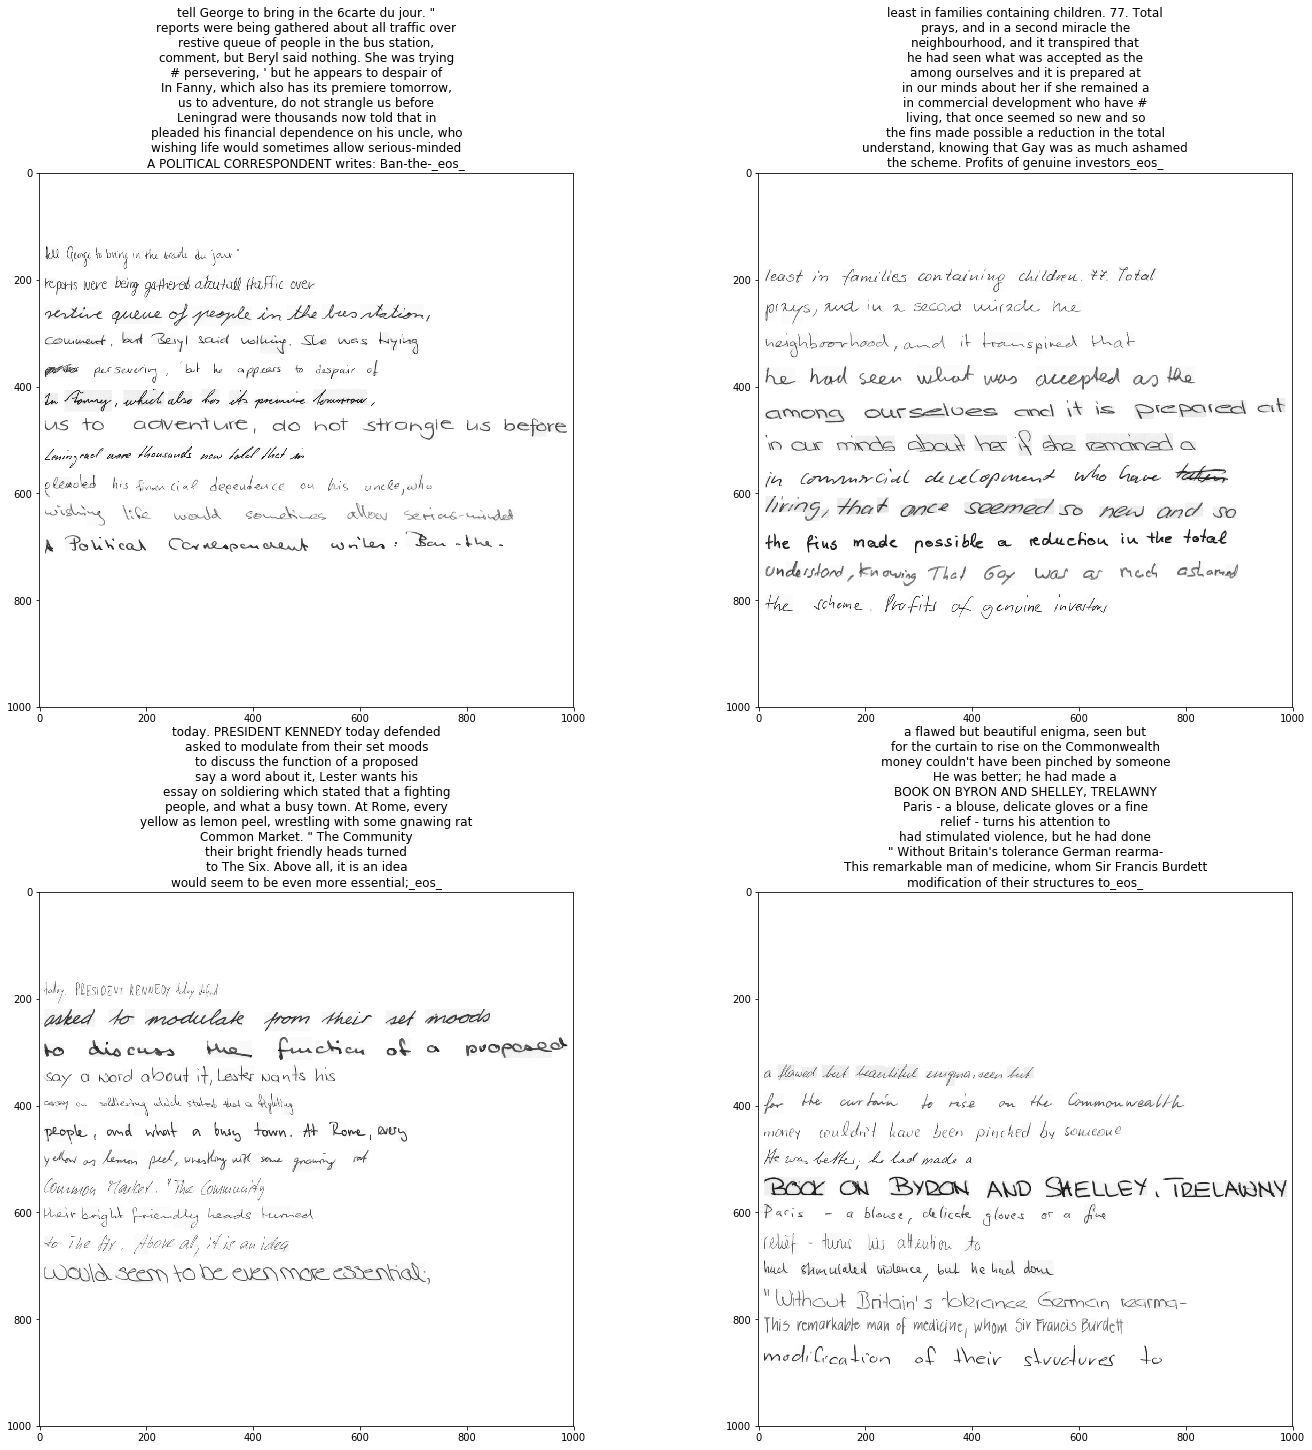

In [64]:
def to_string(row):
    return ''.join([itos[int(c)] for c in row.split(' ')])


fig, axes = plt.subplots(2,2, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    row = a.iloc[i]
    im = Image.open(targ_path/row.filename)
    ax.imshow(im)
    label = to_string(row.char_ids)
#     label = '\n'.join(textwrap.wrap(row.labels, 70))
    ax.set_title(label)

plt.tight_layout(pad=0.2)

## Words

In [ ]:
itos = pickle.load(open(TMP_PATH/'synth_word_itos.pkl', 'rb'))
len(itos)

In [54]:
joined_labels = list(synth.labels)

stoi = collections.defaultdict(lambda: 2, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[word] for word in line.split(' ')]+[3]) for line in joined_labels])

# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [55]:
synth['word_ids'] = str_ids
synth.head()

,filename,labels,char_ids,word_ids
0,10000.png,with carriage verso that content circum- could...,78 64 75 63 1 58 56 73 73 64 56 62 60 1 77 60 ...,5 3542 2 4 1051 2 27 29 2 2 29 1314 66 2 372 3...
1,10001.png,"Referring West 3,000 England cruel strained de...",47 60 61 60 73 73 64 69 62 1 52 60 74 75 1 20 ...,2 156 4251 219 4271 2 2 572 247 483 2495 2429 ...
2,10002.png,tary were made extremes advantage good Greppes...,75 56 73 80 1 78 60 73 60 1 68 56 59 60 1 60 7...,2 11 36 2 1840 53 2 75 902 757 40 16 3061 4 32...
3,10003.png,that make such east brother-in-law forty with ...,75 63 56 75 1 68 56 66 60 1 74 76 58 63 1 60 5...,4 76 74 2 570 1583 5 17 2 373 5 553 277 183 25...
4,10004.png,made late landing whose bone-jarring that Larr...,68 56 59 60 1 67 56 75 60 1 67 56 69 59 64 69 ...,36 326 3833 364 2 4 5856 13 14 250 84 2419 12 ...


### Add to existing CSV

In [56]:
CSV = PATH/'large_synth_word_ids_10000.csv'
csv = pd.read_csv(CSV)

In [57]:
# CSV = PATH/'synth_words_50000.csv'
CSV = PATH/'large_synth_word_ids_50000.csv'

new = pd.concat([csv, synth[['filename', 'word_ids']]], ignore_index=True)
new.to_csv(CSV, columns=['filename', 'word_ids'], index=False)

In [58]:
len(new)

50000

### Modify csv/itos to match previous versions

In [63]:
itos_old = pickle.load(open(TMP_PATH/'synth_word_itos.pkl', 'rb'))

# same as used in single word / multi-word
itos = pickle.load(open(TMP_PATH/'char_itos.pkl', 'rb'))

In [64]:
res = [''.join([itos_old[int(c)] for c in line.split(' ')]) for line in csv.char_ids]
csv['words'] = res
csv.head()

,filename,char_ids,words
0,0000.png,66 55 57 59 13 1 58 59 55 74 62 1 60 69 75 72 ...,lace- death four warily considerably without
1,0001.png,60 69 69 58 1 74 77 59 68 74 63 59 74 62 1 51 ...,food twentieth Western been proved Rhodesia
2,0002.png,74 55 73 65 1 57 62 69 63 57 59 1 56 59 63 68 ...,task choice being longshore which childless
3,0003.png,55 58 76 63 73 59 72 73 1 74 62 55 74 1 35 33 ...,advisers that GENERAL were false example
4,0004.png,59 73 70 59 57 63 55 66 66 79 1 48 62 55 74 1 ...,especially That step rolls know been


In [65]:
joined_labels = list(csv.words) #list(map(lambda x: ' '.join(x), labels))

stoi = collections.defaultdict(lambda: 2, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[letter] for letter in word]+[3]) for word in joined_labels])

In [66]:
# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [72]:
csv['char_ids'] = str_ids
csv = csv[['filename', 'char_ids']]
csv.head()

,filename,char_ids
0,0000.png,67 56 58 60 14 1 59 60 56 75 63 1 61 70 76 73 ...
1,0001.png,61 70 70 59 1 75 78 60 69 75 64 60 75 63 1 52 ...
2,0002.png,75 56 74 66 1 58 63 70 64 58 60 1 57 60 64 69 ...
3,0003.png,56 59 77 64 74 60 73 74 1 75 63 56 75 1 36 34 ...
4,0004.png,60 74 71 60 58 64 56 67 67 80 1 49 63 56 75 1 ...


### Verify

In [31]:
def label_text(pred):
#     ints = to_np(pred).astype(int)
#     ints = np.trim_zeros(ints)   # remove padding (0)
    return ''.join([itos[int(i)] for i in pred])

ValueError: left cannot be >= right

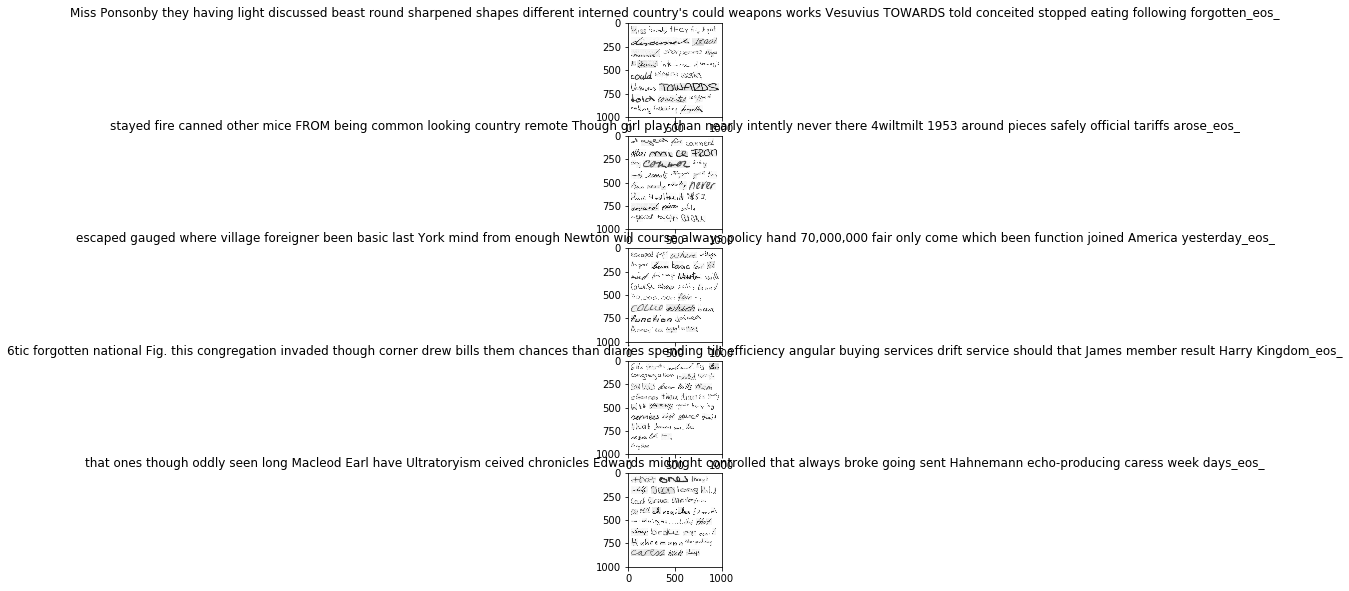

In [34]:
fig, axes = plt.subplots(5,1, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    row = synth.iloc[i]
    im = Image.open(synth_path/row.filename)
    ax.imshow(im)
    ax.set_title(label_text(row.char_ids.split(' ')))
    
plt.tight_layout(pad=0.2)

# Batch Resize

In [60]:
targ_path = PATH/'test_resize'
os.makedirs(targ_path, exist_ok=True)

In [61]:
src_path = PATH/'cat_lines'
# targ_path = PATH/'resized_cat_lines'
# os.makedirs(targ_path, exist_ok=True)

In [65]:
resize_to_square(src_path, targ_path, 1000)

100%|██████████| 100/100 [00:10<00:00,  9.92it/s]


In [62]:
# resize_dir(partial(resize_max, size=512), src_path)
resize_dir(partial(square_max, size=1000), src_path, targ_path)

100%|██████████| 12000/12000 [29:29<00:00,  6.78it/s]
